In [ ]:
# CSV 파일 불러오기
# for vs code
file_path1 = 'data/Meteorological_2019_01.csv'
file_path2 = 'data/서울시_대기질_2019_01.csv'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# CSV 파일 불러오기
# for google colab
file_path1 = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2019_01.csv'
file_path2 = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2019_01.csv'

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv3D, MaxPooling3D
from sklearn.model_selection import train_test_split

In [6]:
# CSV 파일 불러오기
met_data = pd.read_csv(file_path1, usecols=lambda column: column != '지점', encoding='cp949')
air_quality_data = pd.read_csv(file_path2, usecols = ['측정일시', '측정소명', '오존(ppm)'], encoding='cp949')
air_quality_data = air_quality_data[['측정소명', '측정일시', '오존(ppm)']]
print(met_data.columns)
print(air_quality_data.columns)
print(air_quality_data['측정일시'])

# 날짜 및 시간 데이터 처리
met_data['일시'] = pd.to_datetime(met_data['일시'])
air_quality_data['측정일시'] = pd.to_datetime(air_quality_data['측정일시'], format='%Y%m%d%H%M')
air_quality_data = air_quality_data.sort_values(by=['측정소명', '측정일시']).reset_index(drop=True)

Index(['지점명', '일시', '기온(°C)'], dtype='object')
Index(['측정소명', '측정일시', '오존(ppm)'], dtype='object')
0        201901312300
1        201901312300
2        201901312300
3        201901312300
4        201901312300
             ...     
18595    201901010000
18596    201901010000
18597    201901010000
18598    201901010000
18599    201901010000
Name: 측정일시, Length: 18600, dtype: int64


In [7]:
# 'Meteorological data' 측정 지역의 위도와 경도 정보
met_regions_data = {
    'region': ['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청', '마포', '서대문', '광진',
               '성북', '용산', '은평', '금천', '한강', '중구', '성동', '구로', '강북*', '남현', '관악', '영등포', '현충원'],
    'latitude': [37.49794, 37.47650, 37.53010, 37.51456, 37.55095, 37.51656, 37.66877, 37.65526, 37.57491, 37.59508, 37.56556,
                 37.56632, 37.57655, 37.53865, 37.58968, 37.53110, 37.60277, 37.45686, 37.52770, 37.56382, 37.56351, 37.49543,
                 37.646995, 37.46769, 37.47808, 37.52667, 37.50001],
    'longitude': [127.02761, 127.03250, 127.12587, 127.10662, 126.84953, 126.86658, 127.04744, 127.07712, 127.03963, 127.09368, 126.96691,
                  126.90131, 126.93784, 127.08237, 127.01667, 126.97960, 126.93040, 126.89576, 126.99818, 126.99760, 127.03722, 126.88740,
                  127.01371, 126.95818, 126.95143, 126.89636, 126.97422]
}

# DataFrame 생성
met_regions_df = pd.DataFrame(met_regions_data)

# '서울시 대기질 데이터' 각 구의 위도와 경도 정보
air_regions_data = {
    'region': ['종로구', '용산구', '중구', '은평구', '서대문구', '마포구', '광진구', '노원구', '중랑구', '도봉구',
               '성북구', '성동구', '강북구', '동대문구', '동작구', '영등포구', '강서구', '관악구', '양천구', '구로구',
               '금천구', '강남구', '서초구', '강동구', '송파구'],
    'latitude': [37.573050, 37.531100, 37.563820, 37.602770, 37.576550, 37.566320, 37.538650, 37.655260, 37.595080, 37.668770,
                 37.589680, 37.563510, 37.646995, 37.574910, 37.512410, 37.526670, 37.550950, 37.478080, 37.516560, 37.495430,
                 37.456860, 37.497940, 37.476500, 37.530100, 37.514560],
    'longitude': [126.979340, 126.979600, 126.997600, 126.930400, 126.937840, 126.901310, 127.082370, 127.077120, 127.093680, 127.047440,
                  127.016670, 127.037220, 127.013710, 127.039630, 126.941040, 126.896360, 126.849530, 126.951430, 126.866580, 126.887400,
                  126.895760, 127.027610, 127.032500, 127.125870, 127.106620]
}

# DataFrame 생성
air_regions_df = pd.DataFrame(air_regions_data)

In [8]:
# ------------------------------------------------------------------
# 데이터 전처리: 누락된 부분 interpolation
# ------------------------------------------------------------------

# 각 지점명 별로 일시가 744개가 되어야 정상입니다.
expected_timesteps = 744

# 지점명 별로 그룹화하여 일시의 개수를 셉니다.(같은 지점명, )
grouped = met_data.groupby('지점명')['일시'].count()

# 일시가 744개보다 적은 지점들을 찾습니다. (판다스 시리즈 형태로 리턴)
missing_data = grouped[grouped < expected_timesteps]

# 누락된 지점명과 해당 지점의 누락된 일시를 찾습니다.
missing_rows_info = []

for station in missing_data.index:
    station_data = met_data[met_data['지점명'] == station]

    # 1월 1일 00시부터 1월 31일 23시까지의 일시 범위를 생성합니다.
    full_range = pd.date_range(start='2019-01-01 00:00', end='2019-01-31 23:00', freq='H')

    # 누락된 일시를 찾습니다.
    station_data['일시'] = pd.to_datetime(station_data['일시'], errors='coerce', format='%Y-%m-%d %H:%M')
    missing_dates = full_range.difference(station_data['일시'])

    # 누락된 일시가 있을 경우 정보를 저장합니다.
    for missing_date in missing_dates:
        row_info = {'지점명':station, '일시': missing_date}
        missing_rows_info.append(row_info)

# missing row, met_data의 일시를 datetime으로 변환
for row in missing_rows_info:
  row['일시'] = pd.to_datetime(row['일시'], format='%Y-%m-%d %H:%M:%S')

# missing data를 복구.
for missing_row in missing_rows_info:
  location = missing_row['지점명']
  date = missing_row['일시']
  temp_data = met_data[(met_data['지점명']!=location) & (met_data['일시'] == date)]
  tmp = temp_data['기온(°C)'].mean()
  new_row = pd.DataFrame([{'지점명':location, '일시':date, '기온(°C)':tmp}])
  # dataframe에 삽입
  met_data = pd.concat([met_data, new_row], ignore_index = True)


# 정렬
met_data = met_data.sort_values(by=['지점명', '일시']).reset_index(drop=True)

<ipython-input-8-a7a337b2163d>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start='2019-01-01 00:00', end='2019-01-31 23:00', freq='H')
<ipython-input-8-a7a337b2163d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['일시'] = pd.to_datetime(station_data['일시'], errors='coerce', format='%Y-%m-%d %H:%M')
<ipython-input-8-a7a337b2163d>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start='2019-01-01 00:00', end='2019-01-31 23:00', freq='H')
<ipython-input-8-a7a337b2163d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [9]:
# '일시'를 '날짜'와 '시각'으로 분리
met_data['날짜'] = met_data['일시'].dt.date
met_data['시각'] = met_data['일시'].dt.time
air_quality_data['날짜'] = air_quality_data['측정일시'].dt.date
air_quality_data['시각'] = air_quality_data['측정일시'].dt.time

#기존의 일시 열 삭제
# met_data = met_data.drop('일시', axis = 1)
met_data = met_data[['지점명', '날짜', '시각', '기온(°C)']] # 자동으로 column을 drop 시킨다.
# air_quality_data = air_quality_data.drop('측정일시', axis = 1)
air_quality_data = air_quality_data[['측정소명', '날짜', '시각', '오존(ppm)']]

print(met_data)
print(air_quality_data)

       지점명          날짜        시각  기온(°C)
0       강남  2019-01-01  00:00:00    -2.9
1       강남  2019-01-01  01:00:00    -3.7
2       강남  2019-01-01  02:00:00    -4.1
3       강남  2019-01-01  03:00:00    -4.4
4       강남  2019-01-01  04:00:00    -4.8
...    ...         ...       ...     ...
20083  현충원  2019-01-31  19:00:00    -2.9
20084  현충원  2019-01-31  20:00:00    -3.3
20085  현충원  2019-01-31  21:00:00    -3.1
20086  현충원  2019-01-31  22:00:00    -4.0
20087  현충원  2019-01-31  23:00:00    -4.3

[20088 rows x 4 columns]
      측정소명          날짜        시각  오존(ppm)
0      강남구  2019-01-01  00:00:00    0.002
1      강남구  2019-01-01  01:00:00    0.005
2      강남구  2019-01-01  02:00:00    0.002
3      강남구  2019-01-01  03:00:00    0.002
4      강남구  2019-01-01  04:00:00    0.002
...    ...         ...       ...      ...
18595  중랑구  2019-01-31  19:00:00    0.014
18596  중랑구  2019-01-31  20:00:00    0.010
18597  중랑구  2019-01-31  21:00:00    0.012
18598  중랑구  2019-01-31  22:00:00    0.018
18599  중랑구  2019-01-

In [10]:
# 서울시의 위도와 경도 범위 설정
seoul_lat_min, seoul_lat_max = 37.4133, 37.7151  # 서울시 남북 경계 위도
seoul_lon_min, seoul_lon_max = 126.7341, 127.2693  # 서울시 동서 경계 경도

# 그리드 크기 설정 (24x32x32)
grid_size = 32
time_size = 24

# 각 위도와 경도를 그리드 좌표로 변환하는 함수
def latlon_to_grid(lat, lon, lat_min, lat_max, lon_min, lon_max, grid_size):
    # 위도와 경도를 32x32 그리드 좌표로 변환
    row = int((lat - lat_min) / (lat_max - lat_min) * (grid_size - 1))
    col = int((lon - lon_min) / (lon_max - lon_min) * (grid_size - 1))
    return row, col

# -------------------------------
# grid에 meteorological data 저장
# -------------------------------

# grid 선언
regions = met_regions_df['region'].unique()
times = met_data['시각'].unique()
grid_data = np.zeros((31,time_size, grid_size, grid_size, 1))


# 지역별 위도, 경도 -> 그리드 좌표
for region in regions:
    lat = met_regions_df[met_regions_df['region'] == region]['latitude'].values[0]
    lon = met_regions_df[met_regions_df['region'] == region]['longitude'].values[0]
    grid_row, grid_col = latlon_to_grid(lat, lon, seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max, grid_size)

    # 시각별 구분
    time_index = 0
    for time in times:
        met_sub_data = met_data[(met_data['지점명'] == region) & (met_data['시각'] == time)] # meteorological data
        # 기상 데이터를 할당 (온도, 습도, 풍속 데이터)
        grid_data[:, time_index, grid_row, grid_col,0] = met_sub_data['기온(°C)'].values
        time_index += 1

In [11]:
# -------------------------------
# label grid에 오염물질의 농도 매핑
# -------------------------------

# label grid 선언
label_regions = air_regions_df['region'].unique()
label_times = air_quality_data['시각'].unique()
label_grid_data = np.zeros((31,time_size, grid_size, grid_size,1))

# 지역별 위도, 경도 -> 그리드 좌표
for region in label_regions:
    lat = air_regions_df[air_regions_df['region'] == region]['latitude']
    lon = air_regions_df[air_regions_df['region']==region]['longitude']
    l_grid_row, l_grid_col = latlon_to_grid(lat, lon, seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max, grid_size)

    # 시각별 구분
    time_index = 0
    for time in label_times:
        air_sub_data = air_quality_data[(air_quality_data['측정소명'] == region) & (air_quality_data['시각'] == time)]
        label_grid_data[:, time_index, l_grid_row, l_grid_col,0] = air_sub_data['오존(ppm)']
        time_index += 1

<ipython-input-10-85b8b04e0c26>:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  row = int((lat - lat_min) / (lat_max - lat_min) * (grid_size - 1))
<ipython-input-10-85b8b04e0c26>:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  col = int((lon - lon_min) / (lon_max - lon_min) * (grid_size - 1))


In [ ]:
print(label_grid_data[:,0,16,14,0])

[0.005 0.026 0.014 0.002 0.002 0.003 0.002 0.007 0.021 0.002 0.002 0.002
 0.002 0.003 0.011 0.014 0.009 0.012 0.002 0.033 0.022 0.002 0.002 0.018
 0.007 0.026 0.009 0.017 0.025 0.002 0.014]


In [ ]:
X = grid_data
Y = label_grid_data

tf.random.set_seed(1234)

# 모델 생성
model = Sequential([
    Conv3D(32, kernel_size = (3,3,3), activation='relu', input_shape=(24,32,32,1)),
    MaxPooling3D(pool_size = (2,2,2)),
    Conv3D(64, kernel_size = (3,3,3), activation='relu'),
    MaxPooling3D(pool_size = (2,2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(24*32*32, activation = 'linear')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 데이터 변환
Y = Y.reshape(Y.shape[0], -1)

# 모델 학습
model.fit(X, Y, epochs=10, batch_size = 4, validation_split=0.2)

# 모델 평가
loss = model.evaluate(X,Y)
print(f"Loss: {loss}")

# 모델 사용
Ozone_predict = model.predict(X)
Ozone_predict = Ozone_predict.reshape(-1, 24, 32, 32)

print(Ozone_predict)


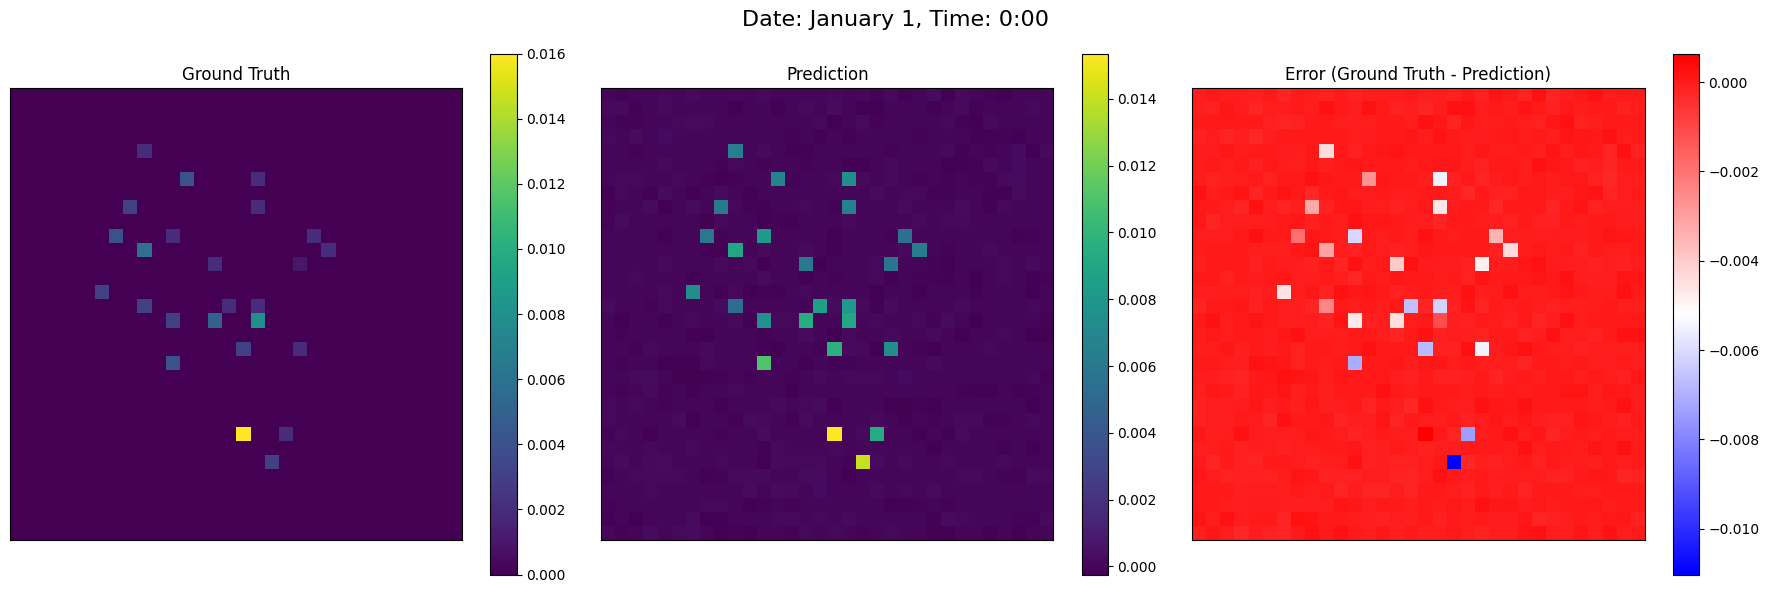

In [17]:
# 시각화 코드

# 이미 학습된 모델의 예측 결과와 실제 데이터를 가지고 있다고 가정합니다.
# Ozone_predict: 모델이 예측한 오존 농도 (shape: [31, 24, 32, 32])
# label_grid_data: 실제 오존 농도 (shape: [31, 24, 32, 32, 1])

# 실제 데이터의 마지막 차원 제거 (차원 맞추기)
ground_truth = label_grid_data[..., 0]  # shape: [31, 24, 32, 32]

# 에러 계산
error = ground_truth - Ozone_predict  # shape: [31, 24, 32, 32]

# 시각화를 위한 함수 정의
def plot_ozone_maps(day_index, hour_index):
    """
    특정 날짜와 시간에 대한 오존 농도의 실제값, 예측값, 에러를 시각화합니다.

    Parameters:
    - day_index (int): 0부터 30까지의 날짜 인덱스 (0은 1월 1일)
    - hour_index (int): 0부터 23까지의 시간 인덱스
    """
    # 데이터 추출
    gt = ground_truth[day_index, hour_index]  # 실제 값
    pred = Ozone_predict[day_index, hour_index]  # 예측 값
    err = error[day_index, hour_index]  # 에러

    # 플롯 설정
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ground Truth 시각화
    im1 = axes[0].imshow(gt, cmap='viridis', interpolation='nearest')
    axes[0].set_title('Ground Truth')
    plt.colorbar(im1, ax=axes[0])

    # Prediction 시각화
    im2 = axes[1].imshow(pred, cmap='viridis', interpolation='nearest')
    axes[1].set_title('Prediction')
    plt.colorbar(im2, ax=axes[1])

    # Error 시각화
    im3 = axes[2].imshow(err, cmap='bwr', interpolation='nearest')
    axes[2].set_title('Error (Ground Truth - Prediction)')
    plt.colorbar(im3, ax=axes[2])

    # 공통 설정
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # 전체 제목 설정
    fig.suptitle(f"Date: January {day_index + 1}, Time: {hour_index}:00", fontsize=16)
    plt.tight_layout()
    plt.show()

# 예시: 1월 1일 0시 데이터를 시각화
plot_ozone_maps(day_index=0, hour_index=0)